## In this notebook we will builds models to classify disaster/non-diaster tweets based on LSTM, 1D convolutions, and word embeddings

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/utils-file/utils.py", dst = "../working/utils.py")
copyfile(src = "../input/constants/constants.py", dst = "../working/constants.py")

In [ ]:
from subprocess import check_output
print(check_output(["ls", "/kaggle/input"]).decode("utf8"))

In [ ]:
from constants import *
from utils import *

In [159]:
from inspect import signature
import re
import string

from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
from sklearn.metrics import (classification_report, accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import tensorflow as tf

import warnings 
  
warnings.filterwarnings(action = 'ignore') 

In [ ]:
%load_ext autoreload
%autoreload 2
    
    
from collections import defaultdict
import os

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
import pandas as pd
import seaborn as sns
import re
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

from multiprocessing import Pool
import os
from inspect import signature
import sys

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

from nltk.tokenize import sent_tokenize, word_tokenize 

import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import (classification_report, accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD

import seaborn as sns


import warnings 
  
warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec 

In [ ]:
# # Set your own project id here
# PROJECT_ID = 'your-google-cloud-project'
# from google.cloud import bigquery
# bigquery_client = bigquery.Client(project=PROJECT_ID)
# from google.cloud import storage
# storage_client = storage.Client(project=PROJECT_ID)

In [78]:
sample_submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
test_df = pd.read_csv("../input/nlp-getting-started/test.csv")
train_df = pd.read_csv("../input/nlp-getting-started/train.csv")

In [79]:
tweets = df=pd.concat([train_df,test_df]).reset_index(drop=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## The the embeddings 

Get the GloVe vectors for every word in our tweet corpus

**First let's clean up the tweets to remove html markup, urls, stopword, stem the words, and convert all to lower case**

In [80]:
table = str.maketrans('', '', string.punctuation)
stop_words = stopwords.words('english')
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
porter = PorterStemmer()


emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

def clean_corpus(tweets):
    tokens = [" ".join(tknzr.tokenize(x)) for x in tweets]

    stripped = [w.translate(table).lower() for w in tokens]

    no_urls = [re.sub(r"http\S+", "", x) for x in stripped]

    no_html = [re.sub(r'<.*?>', "", x) for x in no_urls]

    no_emoji = [emoji_pattern.sub("", x) for x in no_html]

    stopped = [[w for w in sent.split() if not w in stop_words] for sent in no_emoji]

    stemmed = [[porter.stem(word) for word in tokens] for tokens in stopped]

    return [" ".join(words) for words in stemmed]

train_corpus = clean_corpus(train_df["text"].values)
test_corpus = clean_corpus(test_df["text"].values)
corpus = train_corpus + test_corpus

In [81]:
corpus[:2]

['deed reason earthquak may allah forgiv us',
 'forest fire near la rong sask canada']

**Get the embedding (the vectors representing each word in the tweet corpus)**

In [82]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

**Tokenize the tweets**

In [83]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
print(len(word_index))

14865


In [84]:
vocab_size=max_features=len(word_index)

**convert the tweets to word sequences and pad them so they all have the same size. This is necessary as the input to the neural network has a defined size**

In [85]:
sequences = tokenizer.texts_to_sequences(train_corpus)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [86]:
padded

array([[4748,  481,  225, ...,    0,    0,    0],
       [ 128,    5,  177, ...,    0,    0,    0],
       [1298,  521, 1727, ...,    0,    0,    0],
       ...,
       [3096, 3574, 1879, ...,    0,    0,    0],
       [  31,  190, 3453, ...,   98,    0,    0],
       [ 201,   38,  468, ...,    0,    0,    0]], dtype=int32)

In [87]:
training_size=len(train_corpus)

In [88]:
# get the split point, that is the number of samples that will go into the test set
split = int(test_portion * training_size)
split

761

In [89]:
labels = train_df["target"].tolist()

In [90]:
test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [91]:
np.array([training_sequences[0]]).shape

(1, 16)

**Download the GloVe embeddings**

In [92]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
!ls /tmp/glove.6B.100d.txt

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2020-02-18 03:28:04--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   133MB/s    in 2.5s    

2020-02-18 03:28:06 (133 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]

/tmp/glove.6B.100d.txt


In [93]:
# copy the glove file to the workspace
    
# from shutil import copyfile

# # copy our file into the working directory (make sure it has .py suffix)
# copyfile(src = "/tmp/glove.6B.100d.txt", dst = "./glove.6B.100d.txt")
# # copyfile(src = "/tmp/glove.6B.100d.txt", dst = "/kaggle/input/glove.6B.100d.tx")

**Embeddings matrix**

In [94]:
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
        
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

### First Model consists of a 1D convolution and a LSTM layer

It also uses maxpooling, and SpatialDropout1D instead of dropout. It performs the same function as Dropout, however it drops entire 1D feature maps instead of individual elements. If adjacent frames within feature maps are strongly correlated (as is normally the case in early convolution layers) then regular dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease. In this case, SpatialDropout1D will help promote independence between feature maps and should be used instead. 

In [95]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.SpatialDropout1D(0.4),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 16, 100)           1486600   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,551,753
Trainable params: 65,153
Non-trainable params: 1,486,600
_______________________________________

In [96]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_sequences, np.array(training_labels), epochs=num_epochs, validation_data=(test_sequences, np.array(test_labels)), verbose=2)

print("Training Complete")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 16, 100)           1486600   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,551,753
Trainable params: 65,153
Non-trainable params: 1,486,600
_______________________________________

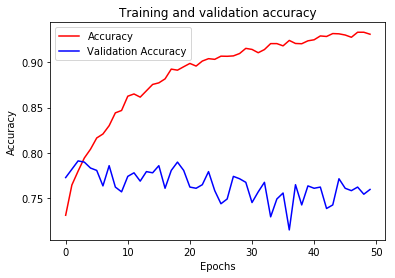

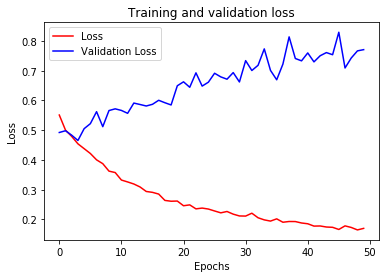

<Figure size 432x288 with 0 Axes>

In [98]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

plt.show()
# Expected Output
# A chart where the validation loss does not increase sharply!

The model seems very overfit. One could also have used a early termination callback since there was no need to train for the 50 epochs.
However, since this is not a very good model, we'll move on to a new, slightly different model.

In the following model we'll remove the first convolution1D and use 2 LSTM layers instead

In [104]:
from keras.layers import Embedding , SimpleRNN, Dense, LSTM, SpatialDropout1D
from keras.initializers import Constant
maxlen = 25
    
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
)

model.add(tf.keras.layers.SpatialDropout1D(0.4))
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.SpatialDropout1D(0.4))
model.add(tf.keras.layers.LSTM(50))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 16, 100)           1486600   
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 16, 100)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 16, 50)            30200     
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 16, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 1,537,051
Trainable params: 50,451
Non-trainable params: 1,486,600
_______________________________________

In [100]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_sequences, np.array(training_labels), epochs=num_epochs, batch_size=64, validation_data=(test_sequences, np.array(test_labels)), verbose=2)

print("Training Complete")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 16, 100)           1486600   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 16, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 16, 50)            30200     
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 16, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 1,537,051
Trainable params: 50,451
Non-trainable params: 1,486,600
_______________________________________

<Figure size 432x288 with 0 Axes>

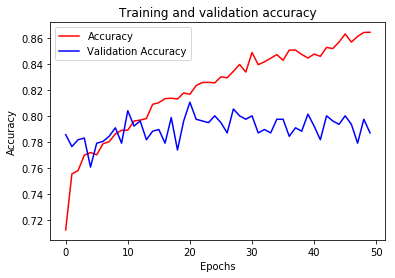

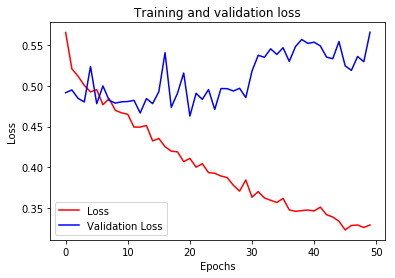

<Figure size 432x288 with 0 Axes>

In [101]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

**The model quickly overfits. Lets train again, but this time add a early stopping callback**

In [105]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
cb_list = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
          ModelCheckpoint(filepath='./best_model.hdf5', verbose=1, save_best_only=True)]

history = model.fit(training_sequences, np.array(training_labels), epochs=num_epochs, batch_size=64, validation_data=(test_sequences, np.array(test_labels)), verbose=2, callbacks=cb_list)

print("Training Complete")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 16, 100)           1486600   
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 16, 100)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 16, 50)            30200     
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 16, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 1,537,051
Trainable params: 50,451
Non-trainable params: 1,486,600
_______________________________________

<Figure size 432x288 with 0 Axes>

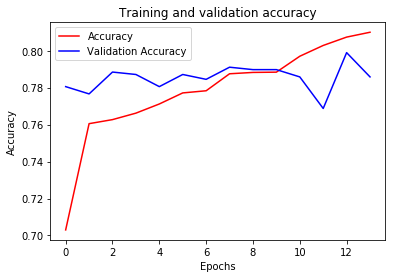

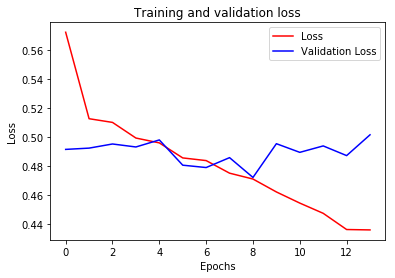

<Figure size 432x288 with 0 Axes>

In [106]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [ ]:
# from IPython.display import HTML
# import pandas as pd
# import numpy as np
# import base64

# # function that takes in a dataframe and creates a text link to  
# # download it (will only work for files < 2MB or so)
# def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
#     csv = df.to_csv()
#     b64 = base64.b64encode(csv.encode())
#     payload = b64.decode()
#     html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
#     html = html.format(payload=payload,title=title,filename=filename)
#     return HTML(html)

# # create a random sample dataframe
# df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))

# # create a link to download the dataframe
# create_download_link(df)

In [108]:
!ls -lh ./best_model.hdf5

-rw-r--r-- 1 root root 6.3M Feb 18 03:37 ./best_model.hdf5


In [109]:
from IPython.display import FileLink
FileLink(r'./best_model.hdf5')

/kaggle/working/best_model.hdf5

In [111]:
len(test_labels)

761

In [119]:
sequences = tokenizer.texts_to_sequences(test_corpus)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [127]:
# test_sequences = tokenizer.texts_to_sequences(train_corpus)  # transform each tweets in to a sequence of integers
# test_data = pad_sequences(test_sequences, maxlen=maxlen, truncating='post', padding='post')  # (longer sequence than threshold will be truncated and shorter sequence will be padded with zeros)

sequences = tokenizer.texts_to_sequences(train_corpus)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

predictions = model.predict(padded)
predictions = np.round(predictions).astype(int).reshape(len(padded))

train_pred = train_df.copy()
train_pred["pred"] = predictions
# Creating submission file 
# submission = pd.DataFrame({'id' : test_df['id'], 'target' : predictions})
# submission.to_csv('final_submission.csv', index=False)

# submission.head()

In [121]:
# test_sequences = tokenizer.texts_to_sequences(train_corpus)  # transform each tweets in to a sequence of integers
# test_data = pad_sequences(test_sequences, maxlen=maxlen, truncating='post', padding='post')  # (longer sequence than threshold will be truncated and shorter sequence will be padded with zeros)

sequences = tokenizer.texts_to_sequences(test_corpus)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

predictions = model.predict(padded)
predictions = np.round(predictions).astype(int).reshape(len(padded))

# Creating submission file 
submission = pd.DataFrame({'id' : test_df['id'], 'target' : predictions})
submission.to_csv('final_submission.csv', index=False)

submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [128]:
from IPython.display import FileLink
FileLink(r'./final_submission.csv')

/kaggle/working/final_submission.csv

In [129]:
train_pred

,id,keyword,location,text,target,pred
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,1


In [132]:
predictions = train_pred["pred"].to_list()

In [134]:
y_test = train_pred["target"].to_list()

In [137]:
print('Accuracy score: ', format(accuracy_score(predictions, y_test )))
print('Precision score: ', format(precision_score(predictions, y_test)))
print('Recall score: ', format(recall_score(predictions, y_test)))
print('F1 score: ', format(f1_score(predictions, y_test)))

Accuracy score:  0.8289767502955471
Precision score:  0.6689085906450627
Recall score:  0.9090153718321562
F1 score:  0.7706939063050369


In [150]:
def plot_confusion_matrix(y_test, predictions):
    labels = [0, 1]
    cm = confusion_matrix(y_test, predictions, labels)
    print(cm)
    labels = ["real", "not"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier', color="red")
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted', color="red")
    plt.ylabel('True', color="red")
    plt.show()

[[4123  219]
 [1083 2188]]


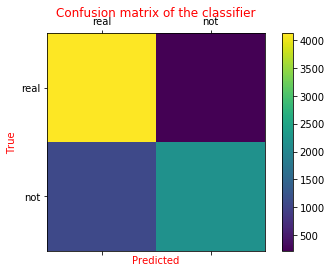

In [151]:
plot_confusion_matrix(y_test, predictions)

In [152]:
fpr, tpr, thresholds = roc_curve(np.array(y_test), predictions, pos_label=1)

In [153]:
roc_auc = auc(fpr, tpr)

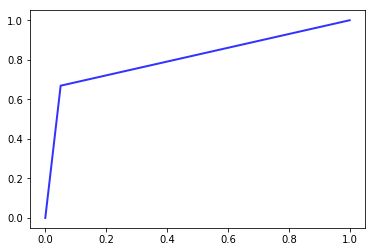

In [154]:
plt.plot(fpr, tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f)' % (roc_auc),
         lw=2, alpha=.8)

The AUC curve has the true positive rate on the y-axis, and the false positive rate on the x axis. Our curve is not very good as after 60% true positive rate the model starts making many false positives.

In [155]:
precision, recall, _ = precision_recall_curve(y_test, predictions)

In [156]:
print(precision, recall)

[0.42965979 0.90901537 1.        ] [1.         0.66890859 0.        ]


In [157]:
average_precision = average_precision_score(y_test, predictions)

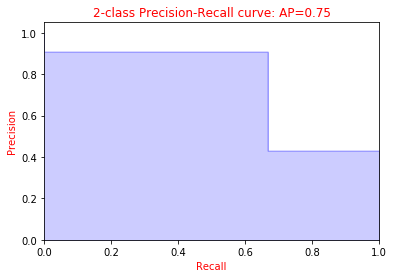

In [162]:
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall', color="red")
plt.ylabel('Precision', color="red")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision), color="red")
print("")

This model achieves a accuracy score of 0.82 on the training set, A Precision score of 0.67, Recall score of 0.91 and F1 score of 0.77.

Remember that accuracy is the number of correct predictions. Precision (positive predictive value) is the fraction of actual positive cases among those classified as positive (ho wmany selected items are relevant), and and recall is the fraction of total positive cases tha were classified as so (how many relevant items are selected). F1 is the harmonic mean between precision and recall.

The model's precision/recall curve is not very good. As the recall increases above 60%, the precision suffers considerably

Of course, we can't actually evaluate the model performance on the test set since this is a kaggle competition and we don't have the ground truth

..or can we? Actually we can download the original dataset from [here](https://www.figure-eight.com/data-for-everyone/). We're going to use the labels of the test data to evaluate our model

In [4]:
original = pd.read_csv("../data/original.csv")

In [16]:
original.head(24)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN
5,778243828,True,golden,140,NaN,Relevant,1.0000,Relevant,NaN,NaN,All residents asked to 'shelter in place' are ...,17.0,NaN
6,778243831,True,golden,142,NaN,Relevant,1.0000,Relevant,NaN,NaN,"13,000 people receive #wildfires evacuation or...",18.0,NaN
7,778243832,True,golden,151,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,19.0,NaN
8,778243833,True,golden,143,NaN,Relevant,1.0000,Relevant,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,20.0,NaN
9,778243834,True,golden,136,NaN,Relevant,0.9606,Relevant\nCan't Decide,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,21.0,NaN


In [12]:
train = pd.read_csv("../data/train.csv")

In [6]:
test = pd.read_csv("../data/test.csv")

In [7]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


As can be seen, the id in the train and test datasets match the row id of the original dataset

In [23]:
test_truth = original.iloc[test['id'].to_list(), :] #[['choose_one']]

Original tweets are labled as 'Relevant' / 'Not Relevant'. Change that to 1/0 label

In [50]:
test_truth['target'] = test_truth.apply(lambda row: int(row['choose_one'] == 'Relevant'), axis=1)

In [31]:
test_truth.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid,target
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN,1
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN,1
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN,1
9,778243834,True,golden,136,NaN,Relevant,0.9606,Relevant\nCan't Decide,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,21.0,NaN,1
11,778243836,True,golden,157,NaN,Relevant,1.0000,Relevant,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,12.0,NaN,1


load the test set predictions by our model

In [34]:
submission = pd.read_csv("../data/final_submission_double_lstm.csv")

In [35]:
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [43]:
submission["actual"] = test_truth['target'].to_list()

In [44]:
submission.head(12)

,id,target,actual
0,0,1,1
1,2,0,1
2,3,1,1
3,9,0,1
4,11,1,1
5,12,0,1
6,21,0,0
7,22,0,0
8,27,0,0
9,29,0,0


Calculate the metrics on the test set

In [45]:
predictions = submission['target']
y_test = submission['actual']

In [48]:
print('Accuracy score: ', format(accuracy_score(predictions, y_test )))
print('Precision score: ', format(precision_score(predictions, y_test)))
print('Recall score: ', format(recall_score(predictions, y_test)))
print('F1 score: ', format(f1_score(predictions, y_test)))

Accuracy score:  0.7802635611400551
Precision score:  0.5998573466476462
Recall score:  0.843530591775326
F1 score:  0.7011254689453938


As expected, the metrics are slighlty worse on the test set, but not by much. 